# Turning ocean model output into “analysis ready data” (ARD)

## Ocean Hack Week 2024 - Australia 

Date: 26 August, 2024

Author = {"name": "Thomas Moore", "affiliation": "CSIRO", "email": "thomas.moore@csiro.au", "orcid": "0000-0003-3930-1946"}

## Goal: calculate SST climatology from a CMIP6 ocean model. **AND do it easily and quickly.**

#### Setting up your ARE session - dialing up your `JobFS` resources

##### Bookmark this information on NCI Queue limits
https://opus.nci.org.au/pages/viewpage.action?pageId=236881198

# Setup your Dask cluster

NB: looks like a work-around in netcdf4-python to deal with netcdf-c not being thread safe was removed in 1.6.1. The solution (for now) is to make sure your cluster only uses 1 thread per worker

Discussion:
https://forum.access-hive.org.au/t/netcdf-not-a-valid-id-errors/389

![open source dependency XKCD](https://www.explainxkcd.com/wiki/images/d/d7/dependency.png)

Credit: XKCD - http://www.xkcd.com

In [1]:
### setup dask cluster
from dask.distributed import Client
client = Client(threads_per_worker=1) # for loading a dataset object from many NetCDF file paths
#client = Client() # possibly better for analysis after loading from an ARD collection / file
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 4,Total memory: 18.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36583,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 18.00 GiB
Comm: tcp://127.0.0.1:42949,Total threads: 1
Dashboard: /proxy/40217/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:44345,


# use CMIP6 data catalogs

The global CMIP6 (Coupled Model Intercomparison Project Phase 6) dataset is enormous, reflecting the extensive range of climate simulations and variables it contains. As of recent estimates, the CMIP6 archive is expected to surpass **20 petabytes (PB)** in total size. This includes data from various modeling centers around the world, covering different experiments, variables, and temporal resolutions.

The total number of NetCDF files in the CMIP6 dataset is immense, with estimates suggesting there are **over 2 million NetCDF files**.

### Information on climate data catalogs across Australian HPC

**ACCESS-NRI** https://access-nri-intake-catalog.readthedocs.io/en/latest/usage/how.html <br>
**NCI** https://opus.nci.org.au/pages/viewpage.action?pageId=213713098


### import some packages

In [22]:
import intake
import xarray as xr
import numpy as np
import gc

### Earth System Grid Federation (ESGF) Australian CMIP6-era Datasets
https://geonetwork.nci.org.au/geonetwork/srv/eng/catalog.search#/metadata/f3154_9976_7262_7595

In [3]:
cmip6_fs38_catalog = intake.open_esm_datastore("/g/data/dk92/catalog/v2/esm/cmip6-fs38/catalog.json")

In [4]:
cmip6_fs38_catalog

,unique
path,1054133
file_type,2
realm,7
frequency,10
table_id,24
project_id,1
institution_id,3
source_id,4
experiment_id,52
member_id,80


In [5]:
cmip6_fs38_catalog.df

,path,file_type,realm,frequency,table_id,project_id,institution_id,source_id,experiment_id,member_id,variable_id,grid_label,version,time_range
0,/g/data/fs38/publications/CMIP6/ScenarioMIP/CS...,f,ocnBgchem,mon,Omon,CMIP,CSIRO,ACCESS-ESM1-5,ssp370,r3i1p1f1,fgco2nat,gn,d20191203,201501-210012
1,/g/data/fs38/publications/CMIP6/ScenarioMIP/CS...,f,land,day,Eday,CMIP,CSIRO,ACCESS-ESM1-5,ssp370,r3i1p1f1,mrsll,gn,d20191203,20200101-20241231
2,/g/data/fs38/publications/CMIP6/ScenarioMIP/CS...,f,land,day,Eday,CMIP,CSIRO,ACCESS-ESM1-5,ssp370,r3i1p1f1,lai,gn,d20191203,20650101-21001231
3,/g/data/fs38/publications/CMIP6/ScenarioMIP/CS...,f,atmos,day,day,CMIP,CSIRO,ACCESS-ESM1-5,ssp370,r3i1p1f1,hursmax,gn,d20191203,20650101-21001231
4,/g/data/fs38/publications/CMIP6/ScenarioMIP/CS...,l,atmos,mon,Amon,CMIP,CSIRO,ACCESS-ESM1-5,ssp370,r20i1p1f1,rlus,gn,v20210525,201501-210012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1054128,/g/data/fs38/publications/CMIP6/DAMIP/CSIRO/AC...,f,atmos,day,day,CMIP,CSIRO,ACCESS-ESM1-5,ssp245-cov-modgreen,r2i1p1f1,ua,gn,d20210316,20500101-20501231
1054129,/g/data/fs38/publications/CMIP6/DAMIP/CSIRO/AC...,l,atmos,mon,Amon,CMIP,CSIRO,ACCESS-ESM1-5,ssp245-cov-modgreen,r2i1p1f1,tauu,gn,v20210316,202001-205012
1054130,/g/data/fs38/publications/CMIP6/DAMIP/CSIRO/AC...,f,ocean,mon,Omon,CMIP,CSIRO,ACCESS-ESM1-5,ssp245-cov-modgreen,r2i1p1f1,hfsso,gn,d20210316,202001-205012
1054131,/g/data/fs38/publications/CMIP6/DAMIP/CSIRO/AC...,l,land,mon,Lmon,CMIP,CSIRO,ACCESS-ESM1-5,ssp245-cov-modgreen,r2i1p1f1,treeFrac,gn,v20210316,202001-205012


### What is the name for SST? Variable name search here: https://pcmdi.llnl.gov/mips/cmip3/variableList.html

In [6]:
my_cmip6_search = cmip6_fs38_catalog.search(
experiment_id="historical",
realm='ocean',
source_id='ACCESS-CM2',
variable_id='tos',
frequency='mon',
file_type='f'
)
my_cmip6_search

,unique
path,15
file_type,1
realm,1
frequency,1
table_id,1
project_id,1
institution_id,1
source_id,1
experiment_id,1
member_id,10


In [7]:
my_cmip6_search.unique().path

['/g/data/fs38/publications/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r5i1p1f1/Omon/tos/gn/files/d20210607/tos_Omon_ACCESS-CM2_historical_r5i1p1f1_gn_185001-201412.nc',
 '/g/data/fs38/publications/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r4i1p1f1/Omon/tos/gn/files/d20210607/tos_Omon_ACCESS-CM2_historical_r4i1p1f1_gn_185001-201412.nc',
 '/g/data/fs38/publications/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r6i1p1f1/Omon/tos/gn/files/d20220819/tos_Omon_ACCESS-CM2_historical_r6i1p1f1_gn_185001-194912.nc',
 '/g/data/fs38/publications/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r10i1p1f1/Omon/tos/gn/files/d20220819/tos_Omon_ACCESS-CM2_historical_r10i1p1f1_gn_195001-201412.nc',
 '/g/data/fs38/publications/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r6i1p1f1/Omon/tos/gn/files/d20220819/tos_Omon_ACCESS-CM2_historical_r6i1p1f1_gn_195001-201412.nc',
 '/g/data/fs38/publications/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r9i1p1f1/Omon/tos/gn/files/d20220819/tos_Omon_ACCESS-CM2_hi

In [8]:
%%time
dataset_dict = my_cmip6_search.to_dataset_dict(progressbar=False)
SST_ds = xr.concat(
    dataset_dict.values(),
    dim='member'
)

ValueError: {'vertices_longitude', 'time_bnds', 'vertices_latitude'} is a coordinate in some datasets but not others.

## ARD task - "Cleaning"

In [9]:
%%time
dataset_dict = my_cmip6_search.to_dataset_dict(progressbar=False)
dataset_dict_clean = {key: ds.drop_vars(['vertices_longitude', 'vertices_latitude', 'time_bnds'], errors='ignore') 
           for key, ds in dataset_dict.items()}
SST_ds = xr.concat(dataset_dict_clean.values(), dim='member')

CPU times: user 1.23 s, sys: 181 ms, total: 1.41 s
Wall time: 2.18 s


In [10]:
SST_ds

<xarray.Dataset> Size: 9GB
Dimensions:    (member: 10, time: 1980, j: 300, i: 360)
Coordinates:
  * time       (time) datetime64[ns] 16kB 1850-01-16T12:00:00 ... 2014-12-16T...
  * j          (j) int32 1kB 0 1 2 3 4 5 6 7 ... 292 293 294 295 296 297 298 299
  * i          (i) int32 1kB 0 1 2 3 4 5 6 7 ... 352 353 354 355 356 357 358 359
    latitude   (j, i) float64 864kB -77.88 -77.88 -77.88 ... 66.04 65.63 65.21
    longitude  (j, i) float64 864kB 80.5 81.5 82.5 83.5 ... 79.96 79.97 79.99
Dimensions without coordinates: member
Data variables:
    tos        (member, time, j, i) float32 9GB dask.array<chunksize=(1, 1, 300, 360), meta=np.ndarray>
Attributes: (12/64)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            36524.0
    creation_date:                    2020-03-06T02:45:16Z
    ...                               ...
    intake_esm_attrs:variable_id:     tos
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:version:         d20200306
    intake_esm_attrs:time_range:      185001-201412
    intake_esm_attrs:_data_format_:   netcdf
    intake_esm_dataset_key:           f.CMIP.CSIRO-ARCCSS.ACCESS-CM2.historic...

## what is the default NetCDF chunking?
`ncdump -hs /g/data/fs38/publications/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r5i1p1f1/Omon/tos/gn/files/d20210607/tos_Omon_ACCESS-CM2_historical_r5i1p1f1_gn_185001-201412.nc`

**tos:_ChunkSizes = 1, 300, 360 ;**

In [11]:
%%time
xarray_open_kwargs = {'chunks':{'member':1,'time':220,'j':300,'i':360}}
dataset_dict = my_cmip6_search.to_dataset_dict(progressbar=False,xarray_open_kwargs=xarray_open_kwargs)
dataset_dict_clean = {key: ds.drop_vars(['vertices_longitude', 'vertices_latitude', 'time_bnds'], errors='ignore') 
           for key, ds in dataset_dict.items()}
SST_ds_chunked_on_open = xr.concat(dataset_dict_clean.values(), dim='member')

CPU times: user 1.18 s, sys: 152 ms, total: 1.34 s
Wall time: 2.08 s


In [12]:
SST_ds_chunked_on_open

<xarray.Dataset> Size: 9GB
Dimensions:    (member: 10, time: 1980, j: 300, i: 360)
Coordinates:
  * time       (time) datetime64[ns] 16kB 1850-01-16T12:00:00 ... 2014-12-16T...
  * j          (j) int32 1kB 0 1 2 3 4 5 6 7 ... 292 293 294 295 296 297 298 299
  * i          (i) int32 1kB 0 1 2 3 4 5 6 7 ... 352 353 354 355 356 357 358 359
    latitude   (j, i) float64 864kB -77.88 -77.88 -77.88 ... 66.04 65.63 65.21
    longitude  (j, i) float64 864kB 80.5 81.5 82.5 83.5 ... 79.96 79.97 79.99
Dimensions without coordinates: member
Data variables:
    tos        (member, time, j, i) float32 9GB dask.array<chunksize=(1, 220, 300, 360), meta=np.ndarray>
Attributes: (12/64)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            36524.0
    creation_date:                    2020-03-06T02:45:16Z
    ...                               ...
    intake_esm_attrs:variable_id:     tos
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:version:         d20200306
    intake_esm_attrs:time_range:      185001-201412
    intake_esm_attrs:_data_format_:   netcdf
    intake_esm_dataset_key:           f.CMIP.CSIRO-ARCCSS.ACCESS-CM2.historic...

# Calculate monthly climatology

In [13]:
SST_climatology = SST_ds.groupby('time.month').mean('time')
SST_climatology

<xarray.Dataset> Size: 54MB
Dimensions:    (month: 12, member: 10, j: 300, i: 360)
Coordinates:
  * j          (j) int32 1kB 0 1 2 3 4 5 6 7 ... 292 293 294 295 296 297 298 299
  * i          (i) int32 1kB 0 1 2 3 4 5 6 7 ... 352 353 354 355 356 357 358 359
    latitude   (j, i) float64 864kB -77.88 -77.88 -77.88 ... 66.04 65.63 65.21
    longitude  (j, i) float64 864kB 80.5 81.5 82.5 83.5 ... 79.96 79.97 79.99
  * month      (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: member
Data variables:
    tos        (month, member, j, i) float32 52MB dask.array<chunksize=(1, 1, 300, 360), meta=np.ndarray>
Attributes: (12/64)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            36524.0
    creation_date:                    2020-03-06T02:45:16Z
    ...                               ...
    intake_esm_attrs:variable_id:     tos
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:version:         d20200306
    intake_esm_attrs:time_range:      185001-201412
    intake_esm_attrs:_data_format_:   netcdf
    intake_esm_dataset_key:           f.CMIP.CSIRO-ARCCSS.ACCESS-CM2.historic...

### Wall time: 3min 25s

In [14]:
%%time
SST_climatology = SST_climatology.compute()

CPU times: user 1min 38s, sys: 4.15 s, total: 1min 42s
Wall time: 3min 16s


In [15]:
gc.collect()

1650

### Wall time: 32.3 s

In [17]:
SST_ARD_climatology = SST_ds_chunked_on_open.groupby('time.month').mean('time')
SST_ARD_climatology

<xarray.Dataset> Size: 54MB
Dimensions:    (month: 12, member: 10, j: 300, i: 360)
Coordinates:
  * j          (j) int32 1kB 0 1 2 3 4 5 6 7 ... 292 293 294 295 296 297 298 299
  * i          (i) int32 1kB 0 1 2 3 4 5 6 7 ... 352 353 354 355 356 357 358 359
    latitude   (j, i) float64 864kB -77.88 -77.88 -77.88 ... 66.04 65.63 65.21
    longitude  (j, i) float64 864kB 80.5 81.5 82.5 83.5 ... 79.96 79.97 79.99
  * month      (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: member
Data variables:
    tos        (month, member, j, i) float32 52MB dask.array<chunksize=(12, 1, 300, 360), meta=np.ndarray>
Attributes: (12/64)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            36524.0
    creation_date:                    2020-03-06T02:45:16Z
    ...                               ...
    intake_esm_attrs:variable_id:     tos
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:version:         d20200306
    intake_esm_attrs:time_range:      185001-201412
    intake_esm_attrs:_data_format_:   netcdf
    intake_esm_dataset_key:           f.CMIP.CSIRO-ARCCSS.ACCESS-CM2.historic...

In [18]:
%%time
SST_ARD_climatology = SST_ARD_climatology.compute()

CPU times: user 4.36 s, sys: 357 ms, total: 4.72 s
Wall time: 31.7 s


# Explore SST climatology over the historical record for ACCESS-CM2

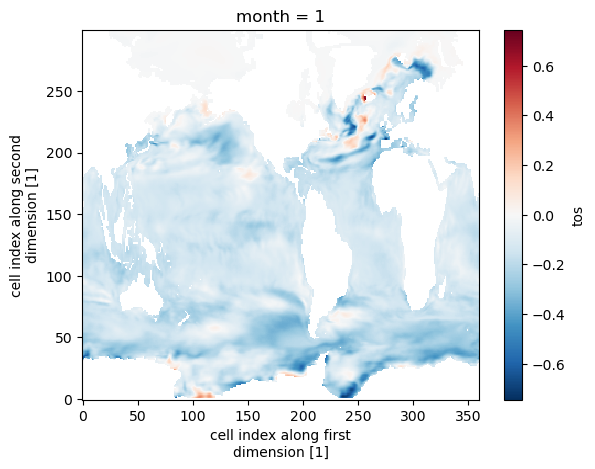

In [36]:
(SST_ARD_climatology.tos.isel({'month':0,'member':0}) - SST_ARD_climatology.tos.isel({'month':0,'member':5})).plot()

# ensemble calculations - "what's the spread in SST"

# Rechunking for ARD ensemble calculations - XL Cluster (14 cpu / 63 GB) used - Wall time: 1min 2s

In [37]:
def remove_encoding(DS):
    for var in DS:
        DS[var].encoding = {}

    for coord in DS.coords:
        DS[coord].encoding = {}
    return DS

In [38]:
SST_ds_rechunked = SST_ds_chunked_on_open.chunk({'member':10,'time':220,'j':300,'i':36})
SST_ds_rechunked

<xarray.Dataset> Size: 9GB
Dimensions:    (member: 10, time: 1980, j: 300, i: 360)
Coordinates:
  * time       (time) datetime64[ns] 16kB 1850-01-16T12:00:00 ... 2014-12-16T...
  * j          (j) int32 1kB 0 1 2 3 4 5 6 7 ... 292 293 294 295 296 297 298 299
  * i          (i) int32 1kB 0 1 2 3 4 5 6 7 ... 352 353 354 355 356 357 358 359
    latitude   (j, i) float64 864kB dask.array<chunksize=(300, 36), meta=np.ndarray>
    longitude  (j, i) float64 864kB dask.array<chunksize=(300, 36), meta=np.ndarray>
Dimensions without coordinates: member
Data variables:
    tos        (member, time, j, i) float32 9GB dask.array<chunksize=(10, 220, 300, 36), meta=np.ndarray>
Attributes: (12/64)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            36524.0
    creation_date:                    2020-03-06T02:45:16Z
    ...                               ...
    intake_esm_attrs:variable_id:     tos
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:version:         d20200306
    intake_esm_attrs:time_range:      185001-201412
    intake_esm_attrs:_data_format_:   netcdf
    intake_esm_dataset_key:           f.CMIP.CSIRO-ARCCSS.ACCESS-CM2.historic...

In [39]:
SST_ds_rechunked.tos.encoding

{'dtype': dtype('float32'),
 'zlib': True,
 'szip': False,
 'zstd': False,
 'bzip2': False,
 'blosc': False,
 'shuffle': False,
 'complevel': 1,
 'fletcher32': False,
 'contiguous': False,
 'chunksizes': (1, 300, 360),
 'preferred_chunks': {'time': 1, 'j': 300, 'i': 360},
 'source': '/g/data/fs38/publications/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r3i1p1f1/Omon/tos/gn/files/d20200306/tos_Omon_ACCESS-CM2_historical_r3i1p1f1_gn_185001-201412.nc',
 'original_shape': (1980, 300, 360),
 'missing_value': 1e+20,
 '_FillValue': 1e+20,
 'coordinates': 'latitude longitude'}

In [40]:
remove_encoding(SST_ds_rechunked)
SST_ds_rechunked.tos.encoding

{}

In [ ]:
%%time
dataset_rechunked.to_zarr('/scratch/nf33/moore_tutorial/SST_ARD_rechunked.zarr',consolidated=True)

# open ARD Zarr collection for SST

In [ ]:
SST_rechunked = xr.open_zarr('/scratch/nf33/moore_tutorial/SST_ARD_rechunked.zarr',consolidated=True)

In [ ]:
SST_rechunked

In [ ]:
client.shutdown()

# $The$ $End$

## Plot current vectors for August

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib.ticker as ticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
from matplotlib import mlab, cm, gridspec
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
%matplotlib inline 

In [ ]:
%%time
# Define the u and v components of the currents
time_choice = 8
u = clim_uv.u.sel(month=time_choice)
v = clim_uv.v.sel(month=time_choice)
speed = np.sqrt(u**2 + v**2)

In [ ]:
#plot model data
transform = ccrs.PlateCarree()
cmap = 'Spectral_r'
cbar_label='current speed'
plot_data = speed

###
fig = plt.figure(num=None, figsize=(8, 6), dpi=300, facecolor='w', edgecolor='k')
ax = plt.subplot(projection=ccrs.PlateCarree(180))
ax.set_extent([142,160, -25, -10], ccrs.PlateCarree())
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='white'))
ax.coastlines('50m',linewidth=0.5,edgecolor='grey')
plot_data.plot(transform=transform,cmap=cmap,cbar_kwargs={'label': cbar_label,'shrink':0.5},robust=True)

#plot u/v vectors
# Define the x and y coordinates
x = clim_uv.xu_ocean
y = clim_uv.yu_ocean
ax.quiver(x.values,y.values,u.values,v.values,transform=transform, units='x', width=0.01, scale=0.7, headwidth=2,alpha=0.2)
ax.set_title('BRAN2020 1993-2022\ncurrent speed \n August Climatology')